# Gaussian Process Regression

Machine learning method that store training data in order to perform new predictions.

Hence, the following considerations must be taken into account before implementing:
- data points less than 10000 (around 1000-5000 should be the best)
- features less than 10

In [1]:
#import libraries
#seaborn can be removed ,but the other ones cannot be removed

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import sklearn
import sys
sns.set(color_codes=True)
%matplotlib inline

Reading reduced data set obtained after applying k-means clustering
This folder should be in the same folder were the python scripts will be
In order case add before the name of the csv file the directory where it is
for instance: "Folder/Folder/.../name.csv" always add .csv at the end of the file

In [2]:
df=pd.read_csv('clustering_30_clean.csv',header=None) # Header=None, otherwise header will be first row of dataset

In [3]:
df   #check the data set that will be used

,0,1,2
0,0.085519,1.638166,0.355081
1,0.079523,1.635425,0.355059
2,0.080781,1.640152,0.354505
3,0.082865,1.634210,0.354986
4,0.084412,1.639296,0.354836
...,...,...,...
955,0.670475,1.133300,0.863174
956,0.665376,1.139958,0.862631
957,0.653530,1.134640,0.862995
958,0.664334,1.140368,0.862970


In [4]:
dataset=df.values   #transform dataset into an array

In [5]:
dataset    #check that data set has been correctly converted to an array

array([[0.0855187 , 1.63816646, 0.35508133],
       [0.07952338, 1.63542474, 0.35505903],
       [0.0807808 , 1.64015221, 0.35450493],
       ...,
       [0.65353037, 1.13463989, 0.86299486],
       [0.66433398, 1.1403681 , 0.86296995],
       [0.6523682 , 1.12696638, 0.86311289]])

In [6]:
X=dataset[:,[1,2]]  # define features in the data set (in this case air and hydrogen volumetric flows)

In [7]:
#X optional if we want to check the input

In [8]:
y=dataset[:,0] # define output , in this case sensor measurement 

In [9]:
#y # optional if we want to check outputs

data preprocessing

In [10]:
#import train_test_split use to slip data set into training set and test set in order to avoid overfitting

from sklearn.model_selection import train_test_split

In [11]:
# define size of our training and tes set
# X_train=features in training set, X_test=features in test set 
# y_train=outputs in training set, y_test=outputs in test set
# test_size=0.3, this is a recommended test size, other options could be used. But it must not be 0. otherwise,
# overfitting will be more likely to occur (poor generalization)
# random_state=0 in order that splitting could be equal for other running of the tes, this number can be any number

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)#always in this order

In [12]:
#X_train # optional to check training inputs

In [13]:
#y_train # optional to check training outputs

In [14]:
# import StandardScaler use to scale our data set. Gaussian process is based in gaussian distribution, therefore
# this scaling is the recommended because it transforms the data set to a data wiht mean value =0 and standard 
# deviation= 1 which is similar to an standard gaussiand distribution

from sklearn.preprocessing import StandardScaler
sc_input=StandardScaler()                      # instantiate StandardScaler
X_train=sc_input.fit_transform(X_train)        # fit StandardScaler to training set
X_test=sc_input.transform(X_test)              # apply the previous fitting to test set

# always in this order: first fit StandardScaler to training set, afterthat apply it to test set

In [15]:
X_train # check training set is correctly rescaled, it is optional but a good way of checking that model is 
        # working good

array([[ 0.9202882 , -0.92334218],
       [ 0.89615448, -0.97585283],
       [ 0.33237149, -0.29382504],
       ...,
       [ 0.31663469, -0.34219296],
       [ 0.21981786, -0.21040964],
       [-0.28851685,  0.3135065 ]])

In [16]:
# do the same for output, similar to the previous step and also always apply in this order

from sklearn.preprocessing import StandardScaler
sc_output=StandardScaler()
y_train=sc_output.fit_transform(y_train.reshape(len(y_train),1)) #y_train needs to be reshape, do not change it
y_test=sc_output.transform(y_test.reshape(len(y_test),1))        #similar for y_test

In [17]:
#y_train  #check y_train, it is optional

In [18]:
print(X_train.shape,np.size(y_train)) #check dimension of x_train, y_train, it is optional buy highly recommended

(672, 2) 672


Building GP model

In [19]:
# import GaussianProcessRegressor import GP model that will be fitted to the data set
# Different kernel (covariance functions) are imported in order to show you more possibilities.
# Kernel= C(1.0,(1e-3,1e3))*RBF(1,(1e-3,1e2)) corresponds to squared exponential gaussian kernel used in this 
# work. C is the signal variance , 1 is the desired value and (1e-3,1e3) are the limits in which the method can 
# estimate it, it means we give beforehand to the model the valus of C where it has to optimize its value.
# Similar to RBF(1,(1e-3,1e2)), 1 is the unit lenght-scale and 1e-3,1e2 are the lower and upper limts where this
# length scale can be optimized. They are given beforehand in order to control the model.

# Rational cuadratic is another kernel option, its parameter are similar to the ones explainedfor RBF Kernel.
# ExpSineSquared is a kernel which is a good option for periodic problems. Periodicity bounds in its must be 
# given in advanced.
# WhiteKernel is for adding artificial noise, it is different to the parameter alpha which is noise but it is used
# for controlling the stability of the model.

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, RationalQuadratic, ExpSineSquared, WhiteKernel

In [20]:
#defining kernels

kernel = C(1.0, (1e-3, 1e3)) * RBF(1, (1e-3, 1e2))
kernel2=RationalQuadratic(length_scale=0.05, alpha=0.05, length_scale_bounds=(1e-02, 10.0), alpha_bounds=(1e-02, 10.0))
kernel3= ExpSineSquared(1, 5, periodicity_bounds=(1e-2, 1e1))+ WhiteKernel(1e-3)

# we are going to instante the model. 
# kernel=kernel defined the kernel used, we can change kernel by kernel1,kernel3 or other such as linear or poly.
# alpha=0.03 is the parameter used to control the stability of the model. A good guess for starting is 0.1 
# then to decrease or increase it until model begins to show an undesired behaviour
# random_state=0 used for model fitting begins at the same point. it could be any number.
# n_restart_optimizer=9 used to run the model n times and pick the best hyperparameters that maximizes the likelihood
# function. It is used in order to avoid choosing a local minima (machine learning methods are susceptible to find them)
# 9 is the recommended value by the developers of the model, otheer values can be also considered.

gp = GaussianProcessRegressor(kernel=kernel,alpha=0.03,random_state=0,n_restarts_optimizer=9)#alpha=0.01

In [21]:
# fit the model to training data set
# measure time that models takes to fit the training data

stime=time.time()
gp.fit(X_train, y_train) #always in this order X_train,y_train
print("Time for ANN fitting: %.3f"%(time.time()-stime))

Time for ANN fitting: 11.524


In [22]:
# measuring prediction time 
stime=time.time()
y_pred,sigma=gp.predict(X_test,return_std=True) #model provides an two outputs: (estimation, standard deviation)
print("Time for GP predictin: %.3f"%(time.time()-stime))

Time for GP predictin: 0.057


Measuring model performance

In [23]:
# import these statistical measure to analize model performance
# r2_score: coefficient of determination , how close are our predictions with respect to real values
# mean_squared_error: mean square error 

from sklearn.metrics import r2_score, mean_squared_error

In [24]:
# printing statistical measures for training and test data

print("mean square error training data: %.5f"% mean_squared_error(y_train,gp.predict(X_train)))
print("mean square error test data: %.5f"% mean_squared_error(y_test,gp.predict(X_test)))
print("R^2 training data: %.5f"% r2_score(y_train,gp.predict(X_train)))
print("R^2 test data: %.5f"% r2_score(y_test,gp.predict(X_test)))

mean square error training data: 0.00353
mean square error test data: 0.00342
R^2 training data: 0.99647
R^2 test data: 0.99684


Plotting the results

In [25]:
#air volumetric flow between 1.7 to 1.1, 100 points in this order in order to increase the equivalence ratios

v_air=np.linspace(1.7,1.1,100) 

In [26]:
#hydrogen volumetric flow between 0.3 to 0.9, 100 points in this order in order to increase the equivalence ratios

v_H2=np.linspace(0.3,0.9,100)

In [27]:
# compute equivalence ratios for a combination of air and hydrogen volumentric flows

rho_H2=0.0836 # hidrogen density m^3/kg
rho_air=1.1972 # air density m^3/kg
rho_N2=1.1639 # nitrogen density m^3/kg
rho_O2=1.3302 # oxigen density m^3/kg
st_ratio_H2_O2=0.125 # Stoichiometric ratio Hidrogen-oxigen
dilrat_air_mfr=4*rho_N2/rho_O2  # Dilation ratio air

# defining function to calculate equivalence ratios

def ratio(x,y):
    mfl_air=(x/1000)*(rho_air/60)
    mfl_H2=(y/1000)*(rho_H2/60)
    mfr_H2=mfl_H2/(mfl_air+mfl_H2)
    mfr_air=mfl_H2/(mfl_air+mfl_H2)
    mfr_O2=(1-mfr_H2)/(1+dilrat_air_mfr)
    return (mfr_H2/mfr_O2)/st_ratio_H2_O2

z=[]      #create list for prediction values 
sigma1=[] #create list for prediction standard deviations
ratios=[] #create list for ratios

# routine to compute equivalence ratios and predicted values given by GP
# inputs in the model bust be enter as a single array, like this example [[1.345,0.987]]
# always scale them , as follow sc_input.transform([[1.345,0.987]])
# gp.preditc([inputs],return_std=True), return_std=True->provide variance, False->only numerical prediction
# always undo the scaling of the output using sc_output.inverse_transform(output)

for i in range(0,len(v_air)):
    z1=gp.predict(sc_input.transform(np.array([v_air[i],v_H2[i]]).reshape(1,-1)),return_std=True)
    z.append(sc_output.inverse_transform(z1[0]))      # adding output to list of outputs
    sigma1.append(z1[1])                              # adding sigma to list of standard deviations
    ratios.append(ratio(v_air[i],v_H2[i]))            # adding ratios using funcion defined above

for i in range(0,len(v_air)):
    sigma1[i]=sigma1[i][0] # converting to a single array ,for instance from [[0.5],[0.6],.,[1]] to [0.5,0.6..,1]

In [28]:
# computing from each data set the mean sensor measurements and mean equivalen ratio in order to plot them
# with the predicted values

import os      #import library to read file from a specific directory

# counting number of files in a directory

max=0
for files in os.listdir('Data/Data_svenja_clean_0.4'):
    max=max+1
print(max)

mean_ratio=[]    # create list to save mean equivalence ratios
mean_sensor=[]   # create list to save mean sensor measurements

#reading each file and calculating mean equivalence ratios and sensor measurements

for j in range(1,max):
    name=os.listdir('Data/Data_svenja_clean_0.4')[j]  # reading first file and extracting its name
    print(name)    # checking names
    
    #reading file at location 'Data/Data_svenja_clean_0.4/' this location can be changed by the user
    dataset=pd.read_csv('Data/Data_svenja_clean_0.4/'+name,header=None) #reading csv file
    X1=dataset.values[:,:]     #converting to array
    mean1=np.mean(X1[:,10])    #computing mean equivalence ratio
    mean_ratio.append(mean1)   #adding previous mean equivalence ratio to list of equivalence ratios
    mean2=np.mean(X1[:,3])     #computing mean sensor measurements
    mean_sensor.append(mean2)  #adding previous mean sensor measurements to a list of sensor measurements

33
data_0.5125_1_0.35_0.05.csv
data_0.525_1_0.35_0.05.csv
data_0.5375_1_0.35_0.05.csv
data_0.55_1_0.35_0.05.csv
data_0.5625_1_0.35_0.05.csv
data_0.575_1_0.35_0.05.csv
data_0.5875_1_0.35_0.05.csv
data_0.5_1_0.35_0.05.csv
data_0.6125_1_0.35_0.05.csv
data_0.625_1_0.35_0.05.csv
data_0.6375_1_0.35_0.05.csv
data_0.65_1_0.35_0.05.csv
data_0.6625_1_0.35_0.05.csv
data_0.675_1_0.35_0.05.csv
data_0.6875_1_0.35_0.05.csv
data_0.6_1_0.35_0.05.csv
data_0.7125_1_0.35_0.05.csv
data_0.725_1_0.35_0.05.csv
data_0.7375_1_0.35_0.05.csv
data_0.75_1_0.35_0.05.csv
data_0.7_1_0.35_0.05.csv
data_0.8_1_0.35_0.05.csv
data_0.9_1_0.35_0.05.csv
data_1.0_1_0.35_0.05.csv
data_1.1_1_0.35_0.05.csv
data_1.2_1_0.35_0.05.csv
data_1.3_1_0.35_0.05.csv
data_1.4_1_0.35_0.05.csv
data_1.5_1_0.35_0.05.csv
data_1.6_1_0.35_0.05.csv
data_1.7_1_0.35_0.05.csv
data_1.8_1_0.35_0.05.csv


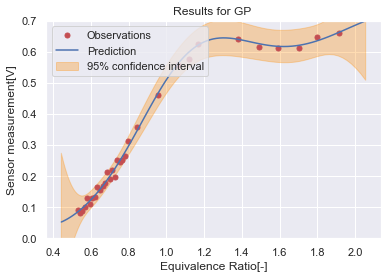

In [29]:
# ploting the results 

z=np.array(z) #converting list to arrays
z=z.reshape(len(v_air),1) #converting to a columna array
sigma1=np.array(sigma1) #converting stadard deviations to an array
#print(z) #using for checking the previous steps, they can be avoid
#print(ratios)
#print(z)
#print(sigma1)
#sigma1=sigma1.reshape(len(v_air),1)


plt.figure()   # defining new figure
plt.plot(mean_ratio, mean_sensor, 'r.', markersize=10, label='Observations') # plotting observations
plt.plot(ratios, z, 'b-', label='Prediction') # plotting predictions
plt.fill_between(ratios, z[:,0] - 1.96*sigma1, z[:,0] + 1.96*sigma1, color='darkorange',
                 alpha=0.3,label='95% confidence interval')  # plotting confidence intervals
plt.title('Results for GP ')    # defining titles
plt.xlabel('Equivalence Ratio[-]')   # x-axis equivalence ratios
plt.ylabel('Sensor measurement[V]')  # y-axis sensor measurements
plt.ylim(0, 0.7)                     # limitins width of y-axis, it can be removed by the user if they want
plt.legend(loc='upper left')         # adding a legend to the plot

Plotting heatmap for showing volumetrics flow respect to temperatures (optional, very time consuming)

In [257]:
u=pd.read_csv('clustering_plot.csv',header=None).values[:,[1,2]]
u1=sc_input.transform(u)
n=u1.shape[0]
x_plot=[]
y_plot=[]
for i in range(0,n):
    x_plot.append(u1[i][0])
    y_plot.append(u1[i][1])

In [259]:
for array in (x_plot,y_plot):
    temp = 0    
    for i in range(0, len(array)):  
        for j in range(i+1, len(array)):  
            if(array[i] > array[j]):  
                temp = array[i] 
                array[i] = array[j]  
                array[j] = temp

x_mesh,y_mesh=np.meshgrid(x_plot,y_plot)
stime=time.time()
z=[]
for j in range(0,np.size(x_plot)):
    for i in range(0,np.size(y_plot)):
        z1=gp.predict([[x_plot[i],y_plot[j]]])
        z.append(sc_output.inverse_transform(z1))
print("Time for GP predicting: %.3f" % (time.time() - stime))

Time for GP predicting: 15.214


[[[0.42929555]]

 [[0.42862255]]

 [[0.42860956]]

 [[0.42825806]]

 [[0.42718293]]

 [[0.42461415]]

 [[0.42448408]]

 [[0.42225052]]

 [[0.42214529]]]
[[0.42932998 0.42865722]
 [0.42935444 0.42868186]
 [0.42935592 0.42868336]
 [0.42936074 0.42868821]
 [0.42936484 0.42869233]
 [0.4293661  0.42869361]
 [0.42937103 0.42869857]
 [0.42937329 0.42870085]
 [0.42937424 0.4287018 ]]


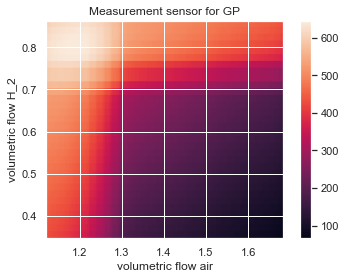

In [31]:
u2=pd.read_csv('clustering_plot.csv',header=None).values[:,[1,2]]
n=u2.shape[0]
x_plot_1=[]
y_plot_1=[]
for i in range(0,n):
    x_plot_1.append(u2[i][0])
    y_plot_1.append(u2[i][1])
for array in (x_plot_1,y_plot_1):
    temp = 0    
    for i in range(0, len(array)):  
        for j in range(i+1, len(array)):  
            if(array[i] > array[j]):  
                temp = array[i] 
                array[i] = array[j]  
                array[j] = temp
                
x_mesh_1,y_mesh_1=np.meshgrid(x_plot_1,y_plot_1)
        
z2=np.array(z)
print(z2[1:10])
z_plot=np.reshape(z2,newshape=(np.size(x_plot_1),np.size(y_plot_1)))
plt.imshow(1000*z_plot,extent=[np.min(x_mesh_1),np.max(x_mesh_1),np.min(y_mesh_1),np.max(y_mesh_1)],interpolation=None,origin='lower')
plt.title('Measurement sensor for GP')
plt.xlabel('volumetric flow air')
plt.ylabel('volumetric flow H_2')
plt.colorbar()
plt.show()